In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras



# LOAD DATA

In [33]:
df = pd.read_csv('datasetiot.csv')
# keep 100 000 first rows
df = df.iloc[:80000]
# add columns empty columns to the dataframe this will be used to store the labels
df['label'] = np.nan
df['label'] = df['label'].astype('category')
#set category types
df['label'].cat.set_categories(['FTP', 'SSH', 'FTP + SSH', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)
df.head()
# line 0 to 5150 is FTP traffic
df.loc[0:5150, 'label'] = 'FTP'
# line 5151 to 18600 is SSH traffic
df.loc[5151:18600, 'label'] = 'SSH'
# line 18601 to 28000 is FTP + SSH traffic
df.loc[18601:26429, 'label'] = 'FTP + SSH'
# line 28000 to 40100 is Keylogger traffic
df.loc[28000:40100, 'label'] = 'Keylogger'
# line 40101 to 46500 is FTP + SSH 
df.loc[40101:46500, 'label'] = 'FTP + SSH'
# line 46501 to 54100 is Reverse Shell
df.loc[46501:54100, 'label'] = 'Reverse Shell'
# line 54101 to 57150 is FTP + SSH
df.loc[54101:57150, 'label'] = 'FTP + SSH'
# the rest is syn flood
df.loc[57151:, 'label'] = 'SYN Flood'




C:\Users\enzoh\AppData\Local\Temp\ipykernel_7076\3653372270.py:8: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['label'].cat.set_categories(['FTP', 'SSH', 'FTP + SSH', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)


# Visulation of the data

In [31]:
# print column names
print(df.columns)

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'label'],
      dtype='object')


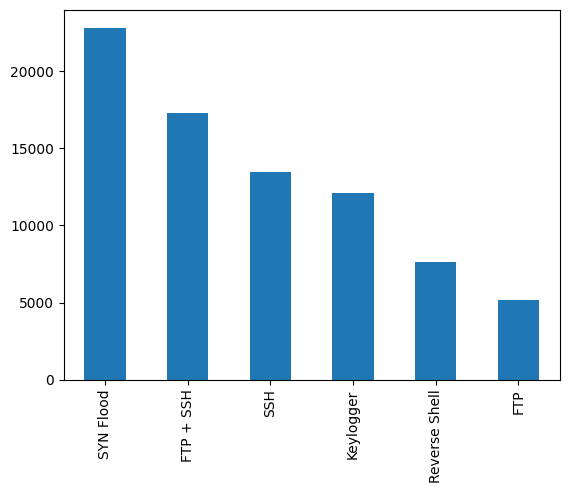

In [34]:
# show and plot  the number of samples for each label
df['label'].value_counts().plot(kind='bar')
plt.show()
# show the number of samples for each label
df['label'].value_counts()
# labels is all the labels
labels = df['label'].values


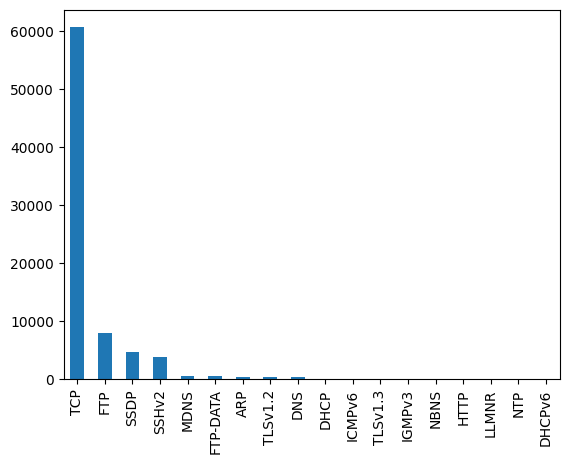

TCP         60676
FTP          8029
SSDP         4664
SSHv2        3798
MDNS          543
FTP-DATA      511
ARP           385
TLSv1.2       354
DNS           352
DHCP          134
ICMPv6        123
TLSv1.3       120
IGMPv3        112
NBNS           72
HTTP           49
LLMNR          48
NTP            24
DHCPv6          6
Name: Protocol, dtype: int64

In [35]:
# show count for each protocol
df['Protocol'].value_counts().plot(kind='bar')
plt.show()
# show count for each protocol
df['Protocol'].value_counts()


# LSTM model

In [6]:
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_data(df, window_size=128):
    """Prepare the data for the LSTM model. Normalize the data, and transform objects to numerical values.

    Args:
        df: pandas dataframe
        window_size: the number of samples to put in a sequence

    Returns:
        Tuple: X, y
            - X (np.array): Features.
            - y (np.array): Labels.
    """

    # Extract relevant features
    X = df.drop('label', axis=1)  # Drop the label column
    y = df['label']

    # Label encoding for categorical columns
    label_encoder = LabelEncoder()
    X_encoded = X.apply(label_encoder.fit_transform)  # Apply label encoding to all columns

    # encode the labels
    y_encoded = label_encoder.fit_transform(y)


    # Create sliding window sequences of data
    num_samples = len(X_encoded)
    num_features = X_encoded.shape[1]
    X_sequences = np.zeros((num_samples - window_size + 1, window_size, num_features))
    y_labels = np.zeros((num_samples - window_size + 1,), dtype=int)
    for i in range(num_samples - window_size + 1):
        X_sequences[i] = X_encoded[i:i + window_size]
        y_labels[i] = y_encoded[i + window_size - 1]
    return X_sequences, y_labels, label_encoder

    





In [36]:
# Define the indices for training, validation, and test sets
train_indices = [(0, 3500), (5150, 13000), (18600, 24500), (28000, 35000), (40100, 44500), (46500, 51500), (int(54101), int((len(df)-54101)*0.8))]
val_indices = [(3501, 4300), (13001, 15500), (24501, 26500), (35001, 37500), (44501, 45000), (51501, 52000), (int((len(df)-54101)*0.8), int((len(df)-54101)*0.9))]
test_indices = [(4301, 5150), (15501, 18600), (26501, 28000), (37501, 40100), (45001, 46500), (52001, 54100), (int((len(df)-54101)*0.9), int(len(df)-54101))]

# create the training, validation, and test dataframes, including the parts inside each tuple
train_df = pd.concat([df.iloc[start:end] for start, end in train_indices])
val_df = pd.concat([df.iloc[start:end] for start, end in val_indices])
test_df = pd.concat([df.iloc[start:end] for start, end in test_indices])

# print shapes
print(train_df.shape, val_df.shape, test_df.shape)

# reset the indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


#print all dtypes
print(train_df.dtypes)
print(val_df.dtypes)
print(test_df.dtypes)
window_size = 128
train_df_data, train_target,label_encoder_train = prepare_data(train_df, window_size)
val_df_data, val_target,label_encoder_val = prepare_data(val_df, window_size)
test_df_data, test_target, label_encoder_test= prepare_data(test_df, window_size)
# print("aaaaaaaaaaaaa",train_df_data.shape, train_target.shape)
# val_df_data, val_target = prepare_data(val_df)
# test_df_data, test_target = prepare_data(test_df)
# num_features = train_df_data.shape[2]




(33650, 8) (11384, 8) (14234, 8)
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object


In [48]:
# train lstm smodel_stacked_LSTM
num_features = train_df_data.shape[2]
input_shape = (window_size, num_features)

smodel_stacked_LSTM = keras.Sequential()
smodel_stacked_LSTM.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(128, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(64, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(64))
smodel_stacked_LSTM.add(keras.layers.Dense(32, activation='relu'))
smodel_stacked_LSTM.add(keras.layers.Dense(7, activation='softmax'))
smodel_stacked_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
smodel_stacked_LSTM.summary()

model_single_LSTM = keras.Sequential()
model_single_LSTM.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
model_single_LSTM.add(keras.layers.LSTM(64))
model_single_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_single_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_single_LSTM.summary()

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model_CNN.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN.add(keras.layers.Flatten())
model_CNN.add(keras.layers.Dense(50, activation='relu'))
model_CNN.add(keras.layers.Dense(7, activation='softmax'))
model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN.summary()

model_CNN2 = keras.Sequential()
model_CNN2.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model_CNN2.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model_CNN2.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN2.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model_CNN2.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN2.add(keras.layers.Flatten())
model_CNN2.add(keras.layers.Dense(50, activation='relu'))
model_CNN2.add(keras.layers.Dense(7, activation='softmax'))
model_CNN2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN2.summary()



model_CNN_LSTM = keras.Sequential()
model_CNN_LSTM.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model_CNN_LSTM.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN_LSTM.add(keras.layers.LSTM(128, return_sequences=True))
model_CNN_LSTM.add(keras.layers.LSTM(64))
model_CNN_LSTM.add(keras.layers.Dense(32, activation='relu'))
model_CNN_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_CNN_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN_LSTM.summary()

model_bidirectional_LSTM = keras.Sequential()
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True), input_shape=input_shape))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_bidirectional_LSTM.add(keras.layers.Dense(32, activation='relu'))
model_bidirectional_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_bidirectional_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidirectional_LSTM.summary()

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.SimpleRNN(128, input_shape=input_shape, return_sequences=True))
model_RNN.add(keras.layers.SimpleRNN(128, return_sequences=True))
model_RNN.add(keras.layers.SimpleRNN(64))
model_RNN.add(keras.layers.Dense(32, activation='relu'))
model_RNN.add(keras.layers.Dense(7, activation='softmax'))
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_RNN.summary()


model_list = [smodel_stacked_LSTM, model_single_LSTM, model_CNN, model_CNN_LSTM, model_bidirectional_LSTM, model_RNN]




Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 128, 128)          69632     
                                                                 
 lstm_23 (LSTM)              (None, 128, 128)          131584    
                                                                 
 lstm_24 (LSTM)              (None, 128, 64)           49408     
                                                                 
 lstm_25 (LSTM)              (None, 64)                33024     
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 7)                 231       
                                                                 
Total params: 285,959
Trainable params: 285,959
Non-t

In [9]:
# show how len many unique labels there are
print(len(np.unique(train_target)))

6


In [10]:
smodel_stacked_LSTM.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          69632     
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          131584    
                                                                 
 lstm_2 (LSTM)               (None, 128, 64)           49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 285,959
Trainable params: 285,959
Non-trai

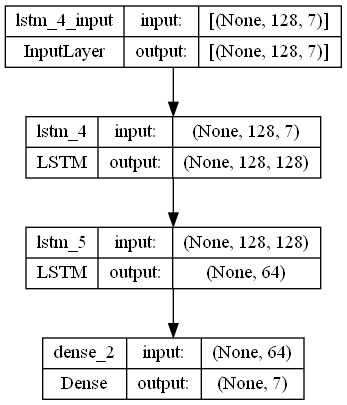

In [24]:
#draw model
from keras.utils.vis_utils import plot_model
plot_model(smodel_stacked_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# plot single model
plot_model(model_single_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



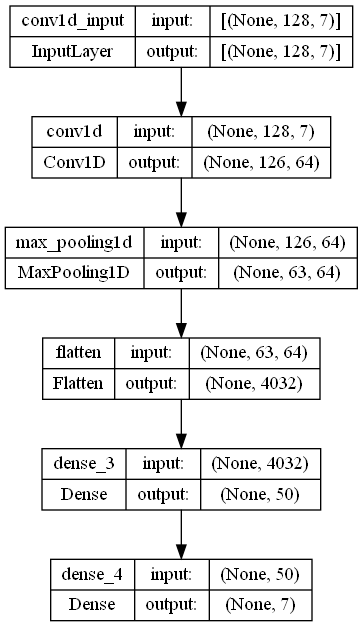

In [25]:
plot_model(model_CNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

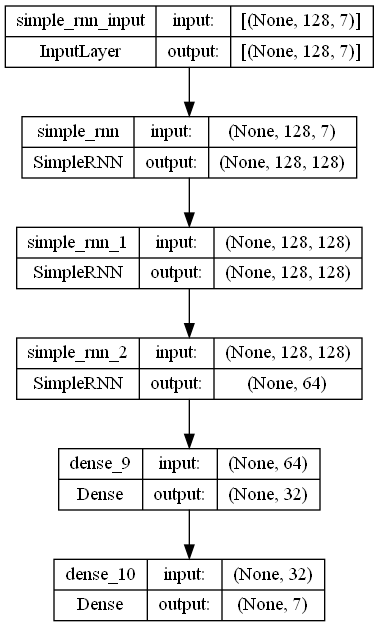

In [26]:
plot_model(model_RNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

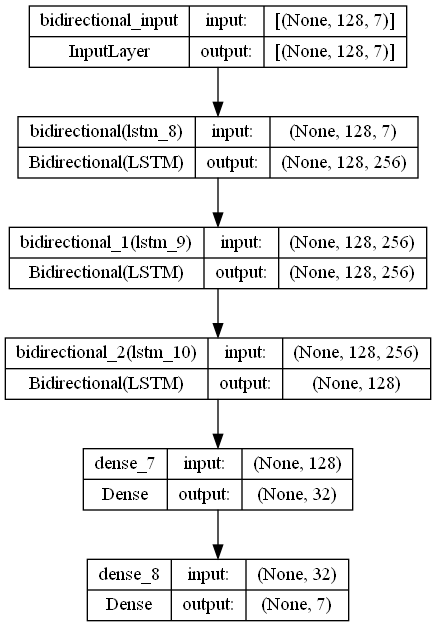

In [27]:
plot_model(model_bidirectional_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

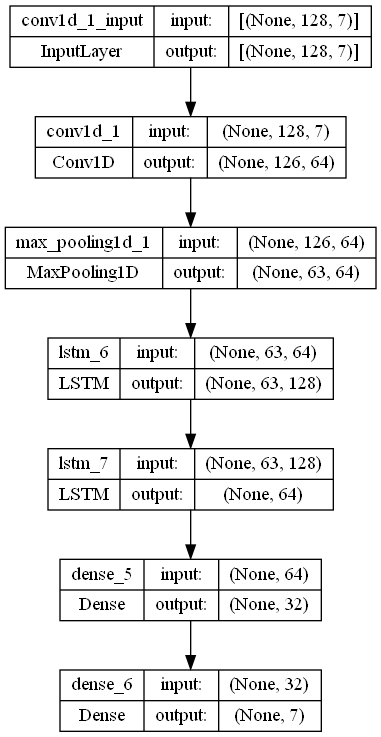

In [28]:
plot_model(model_CNN_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
#show GPU info
!nvidia-smi


Wed Apr  5 02:21:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0    29W / 141W |   6055MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
# clear memory of tensorflow
import tensorflow as tf
tf.keras.backend.clear_session()


In [54]:

# history_single_LSTM = model_single_LSTM.fit(train_df_data, train_target, epochs=25, batch_size=64, validation_data=(val_df_data, val_target))
# history_CNN = model_CNN.fit(train_df_data, train_target, epochs=100, batch_size=128, validation_data=(val_df_data, val_target))
# history_CNN2 = model_CNN2.fit(train_df_data, train_target, epochs=100, batch_size=128, validation_data=(val_df_data, val_target))
# history_CNN_LSTM = model_CNN_LSTM.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))
# history_bidirectional_LSTM = model_bidirectional_LSTM.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))
# history_RNN = model_RNN.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))
history_stacked_LSTM = smodel_stacked_LSTM.fit(train_df_data, train_target, epochs=25, batch_size=256, validation_data=(val_df_data, val_target))

Epoch 1/25
131/131 [==============================] - 11s 63ms/step - loss: 0.3916 - accuracy: 0.8816 - val_loss: 0.6010 - val_accuracy: 0.8002
Epoch 2/25
131/131 [==============================] - 8s 61ms/step - loss: 0.1972 - accuracy: 0.9381 - val_loss: 0.3541 - val_accuracy: 0.8850
Epoch 3/25
 66/131 [==============>...............] - ETA: 3s - loss: 0.1886 - accuracy: 0.9437

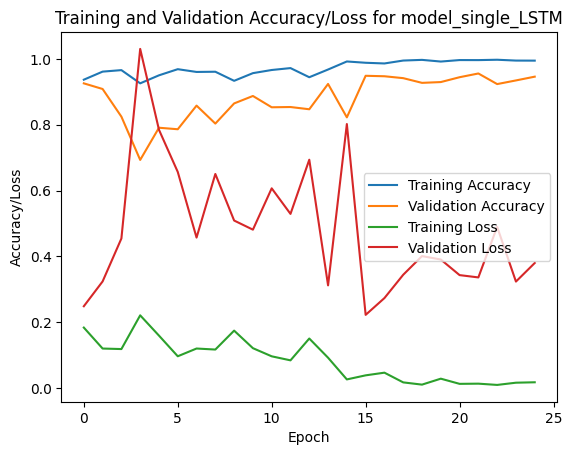

In [44]:
history = history_single_LSTM.history
import matplotlib.pyplot as plt

# Get the training history
model_name = 'model_single_LSTM'
# Plot the training and validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Plot the training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Set the x and y axis labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')

# Set the title and legend
plt.title('Training and Validation Accuracy/Loss for ' + model_name)
plt.legend()

# Show the plot
plt.show()

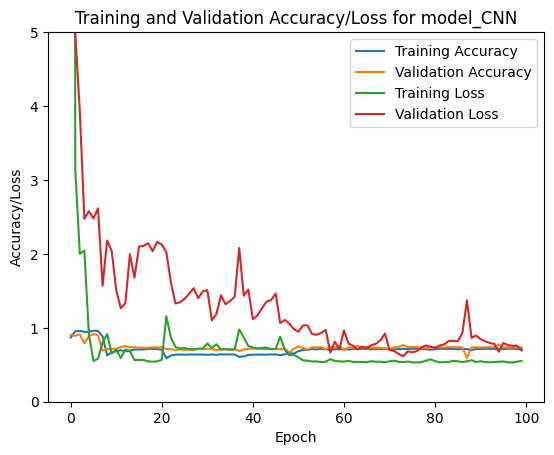

In [53]:
# same flot for CNN
history = history_CNN2.history
import matplotlib.pyplot as plt

# Get the training history
model_name = 'model_CNN'
# Plot the training and validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Plot the training and validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Set the x and y axis labels
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
# cut y axis to 5
plt.ylim(0, 5)

# Set the title and legend
plt.title('Training and Validation Accuracy/Loss for ' + model_name)
plt.legend()

# Show the plot
plt.show()


In [50]:
# save model
# model_single_LSTM.save('model_single_LSTM.h5')
model_CNN.save('model_CNN.h5')

In [17]:
# show confusion matrix with original labels
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model_bidirectional_LSTM.predict(test_df_data)


1761/1761 [==============================] - 44s 25ms/step


['FTP' 'FTP' 'FTP' ... 'SYN Flood' 'SYN Flood' 'SYN Flood']
[[4.23474972e-07 6.56152395e-07 1.31381045e-10 ... 9.99998927e-01
  1.74619359e-08 1.11875724e-10]
 [8.61764704e-07 2.54186170e-06 6.45748011e-10 ... 9.99996543e-01
  5.54689272e-08 3.72186643e-10]
 [1.76765957e-06 5.33530465e-06 1.64171321e-09 ... 9.99992609e-01
  9.52259924e-08 7.24309224e-10]
 ...
 [1.21299074e-14 5.23425227e-11 2.27604042e-15 ... 4.47301243e-15
  1.00000000e+00 1.01709889e-19]
 [1.30637265e-14 5.41270744e-11 2.43071965e-15 ... 4.73664170e-15
  1.00000000e+00 1.08962382e-19]
 [1.38872610e-14 5.63502821e-11 2.58687589e-15 ... 5.03027541e-15
  1.00000000e+00 1.16797928e-19]]
Confusion Matrix:
[[    0     0     0     0   722     0     0]
 [    0   269     0     0    12  1218     0]
 [    0   982     0    12     0  1605     0]
 [    0     0     0     0     0  2099     0]
 [    0     3     0     0  3096     0     0]
 [    0     0     0     0     0 44810     0]
 [    0   149     0     0  1234   116     0]]


c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

          FTP       0.00      0.00      0.00       722
    FTP + SSH       0.19      0.18      0.19      1499
    Keylogger       0.00      0.00      0.00      2599
Reverse Shell       0.00      0.00      0.00      2099
          SSH       0.61      1.00      0.76      3099
    SYN Flood       0.90      1.00      0.95     44810
          nan       0.00      0.00      0.00      1499

     accuracy                           0.86     56327
    macro avg       0.24      0.31      0.27     56327
 weighted avg       0.75      0.86      0.80     56327



c:\Users\enzoh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


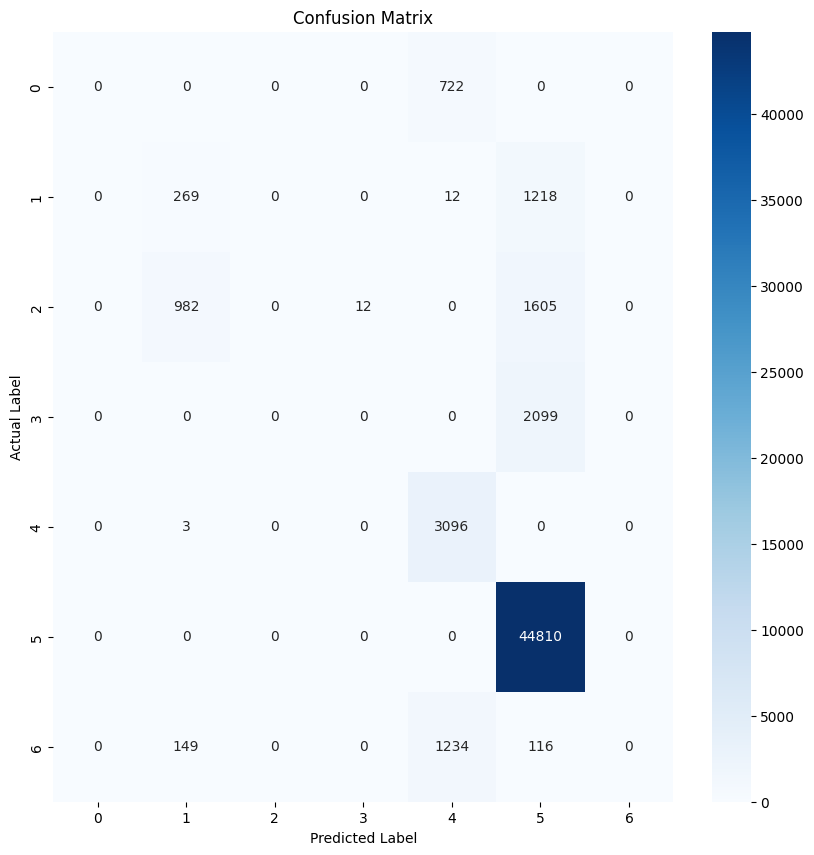

In [22]:
y_pred_labels = np.argmax(y_pred, axis=1)


reverse_label_map = {label_encoder_test.transform([label])[0]: label for label in label_encoder_test.classes_}

# Map the encoded labels back to original labels using the reverse mapping
y_true = np.vectorize(reverse_label_map.get)(test_target)
y_pred_labels = np.vectorize(reverse_label_map.get)(y_pred_labels)
print(y_true)
print(y_pred)

# Print confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
print('Confusion Matrix:')
print(cm)

# Print classification report
cr = classification_report(y_true, y_pred_labels)
print('Classification Report:')
print(cr)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

